In [1]:
# Import packages
import os
import argparse
import time
import numpy as np
import pylab as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
from utils.graphic_tools import simple_plotter, show_state, show_err, animate_plot, visualize_u_from_F, double_plotter
from utils.analysis_tools import relative_err, rmse, check_weights, downsampling
from utils.models import HeatModel

from equations.heat import get_heat, get_heat_grad_t, get_heat_fd, get_heat_fd_impl, get_heat_fft
from equations.initial_functions import random_init, high_dim_random_init, heat_analytical_init

from generators import heat_snapshot_generator, get_heat_batch
from training_dataset import generate_heat_training_dataset, read_dataset

<IPython.core.display.Javascript object>


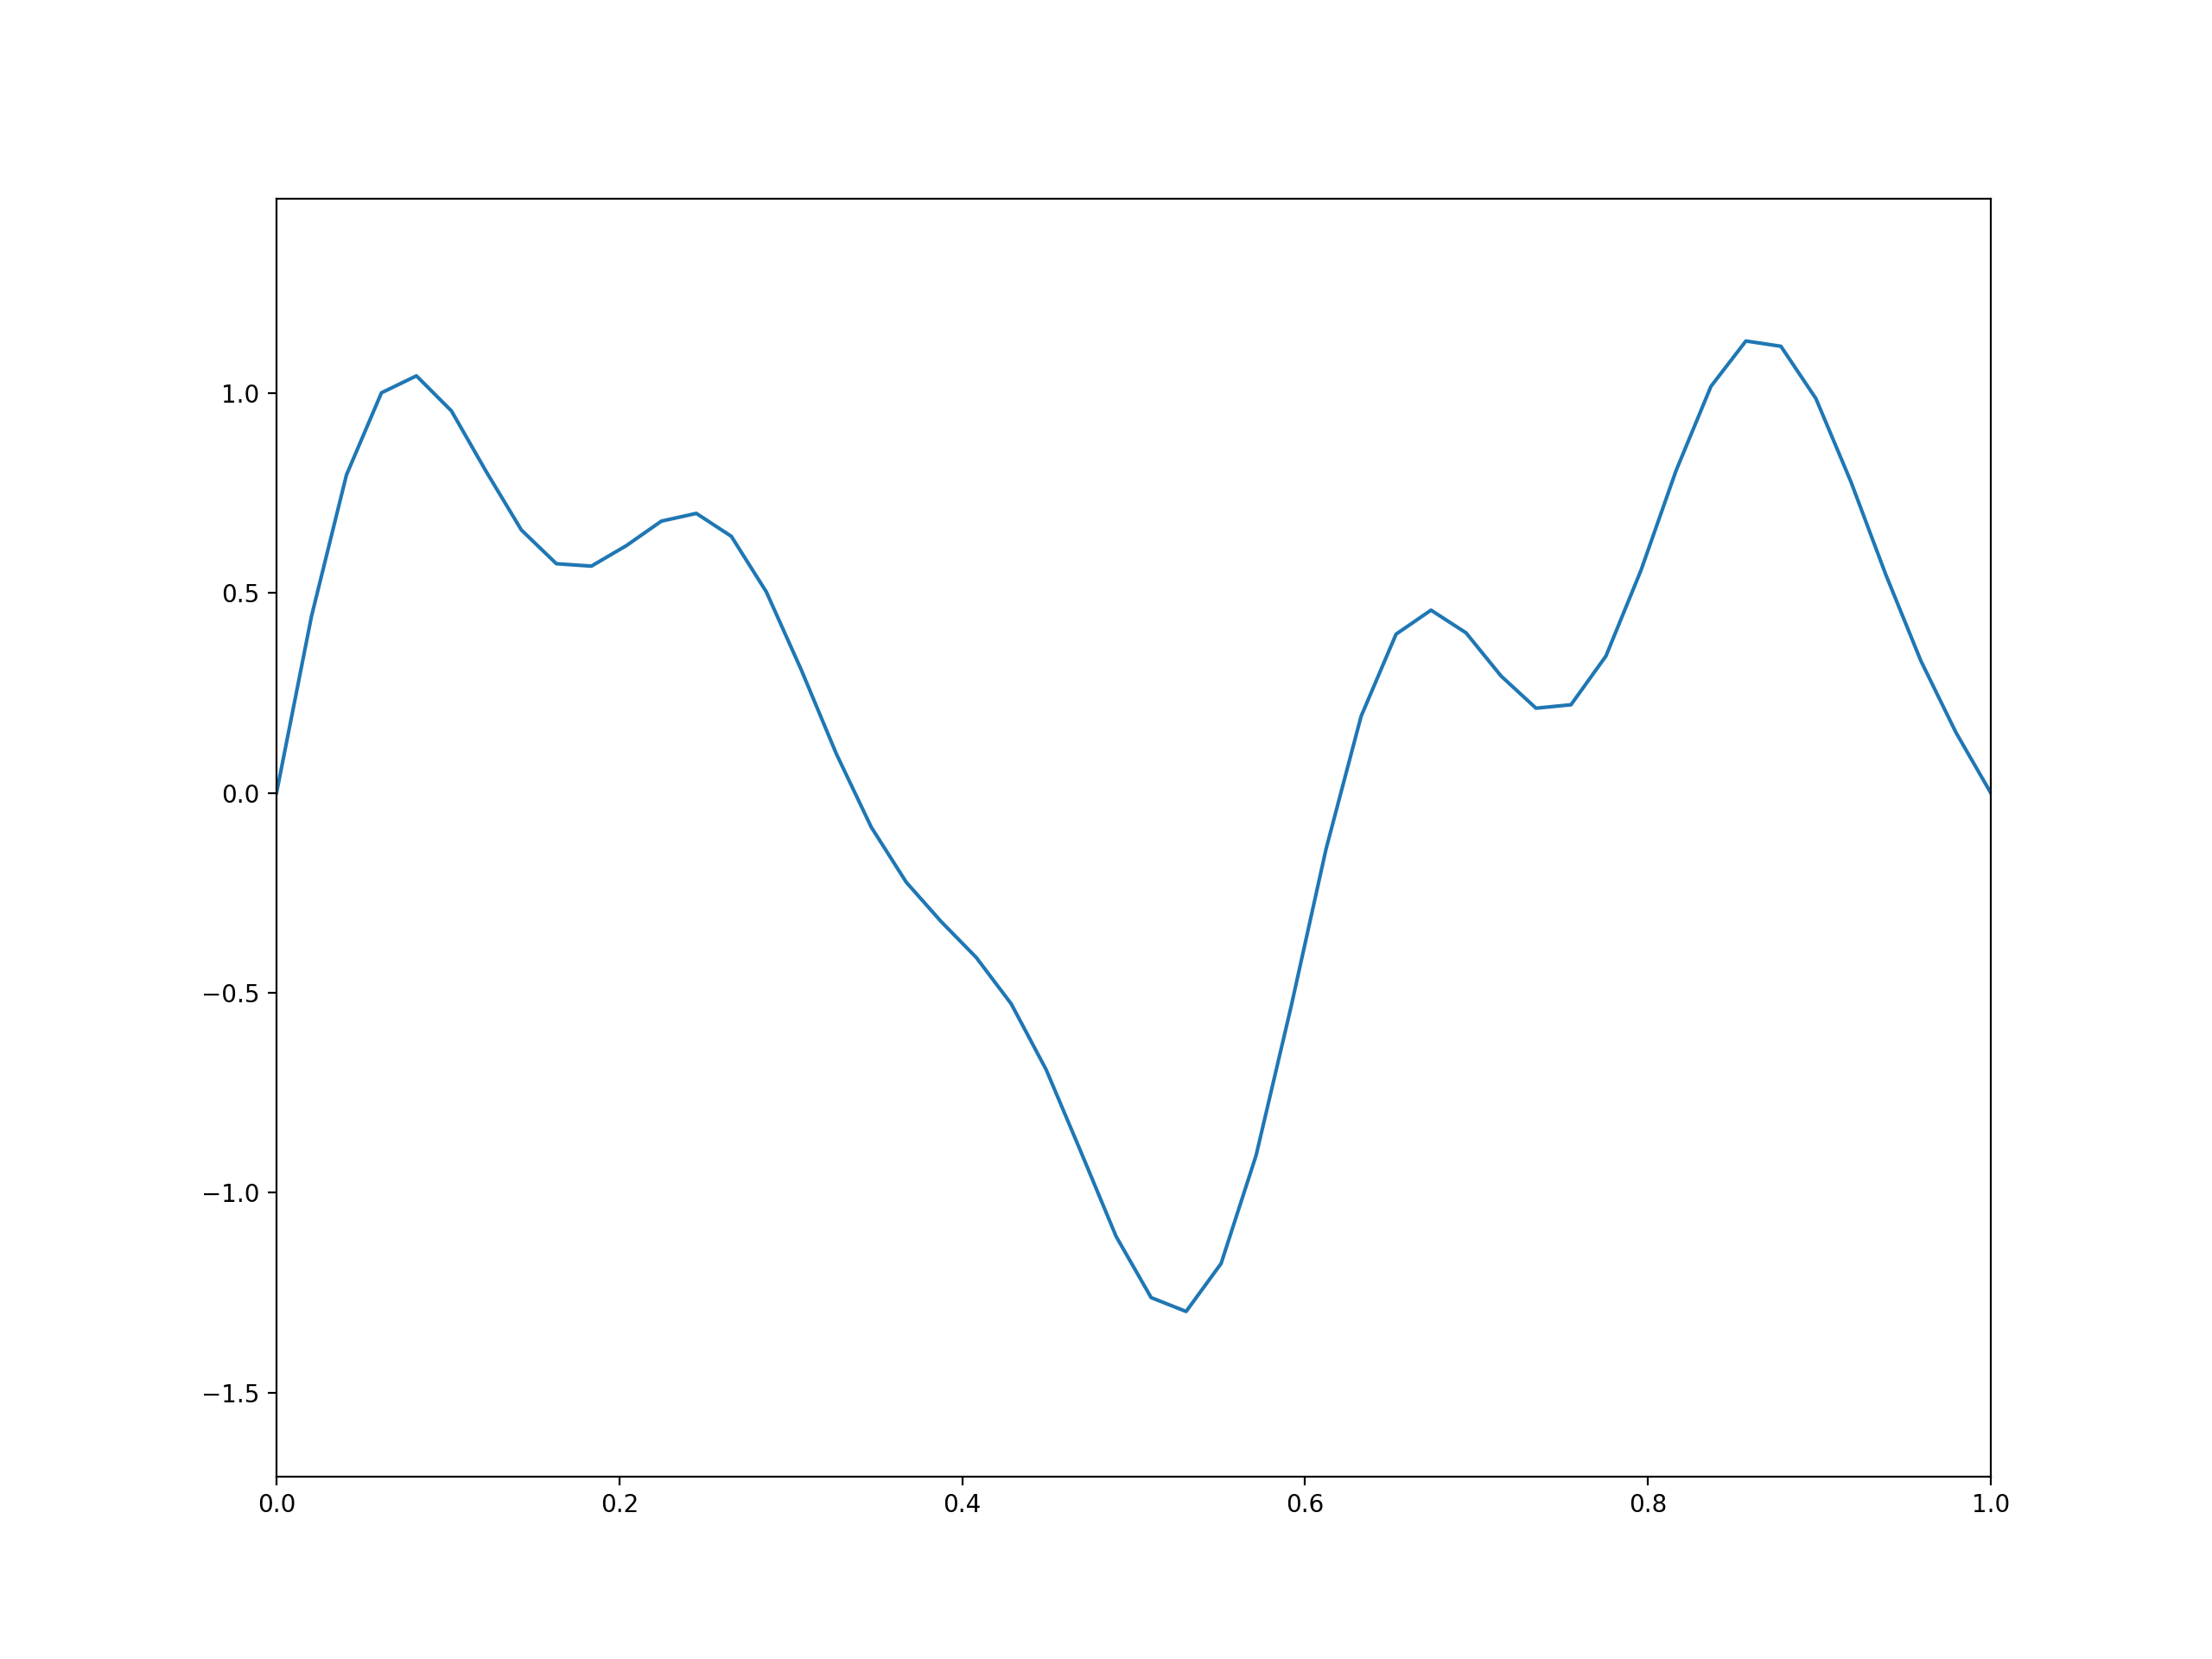

In [3]:
%matplotlib notebook

t_max = 1.0
t_min = 0.01
x_max = 1.
x_min = 0.
t_n = 50
x_n = 50

t = np.linspace(t_min, t_max, t_n)
x = np.linspace(x_min, x_max, x_n)

u_true, cn = get_heat(t, x, [3, 7, 10], [0.7, 0.3, 0.4], 0.005)

outer_ani = animate_plot(u_true, x)

### Different methods

We make usage of different method to evaluate a solution to the heat equation. Starting from the well-known analytical solution to the equation $u(x,t) = \sum^{\inf}_{n=1} c_n e^{-\pi^2 n^2 t} sin(n \pi x)$,
we implemented as well explicit, implicit finite-difference and finite-element solutions.

While for testing the quality of our implementation we started with the analytical solution, in the case of heat equation it is interesting to continue with the implicit finite-difference, a numerically stable solution for a large range of parameters.

In [228]:
t_max = 1.0
t_min = 0.01
x_max = 1.
x_min = 0.
t_n = 64
x_n = 64

k = 0.005
c = [0.7, 0.3, 0.4]
n = [3, 7, 10]

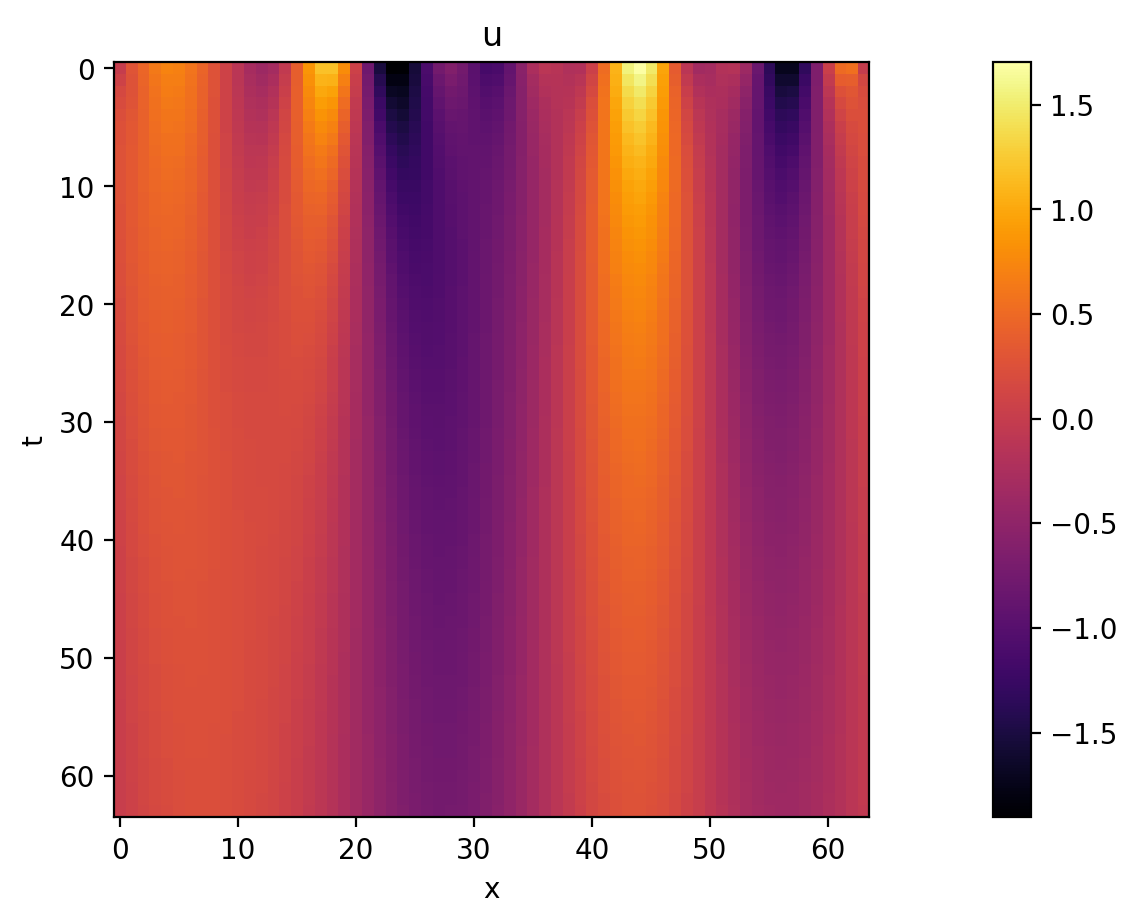

In [5]:
%matplotlib inline
t, dt = np.linspace(t_min, t_max, t_n, retstep=True)
x, dx = np.linspace(x_min, x_max, x_n, retstep=True)

u = heat_snapshot_generator(t_max, t_min, x_max, x_min, t_n, x_n, -1, 1, k)
show_state(u, 'u')

In [237]:
dataset = generate_heat_training_dataset(t_max, t_min, x_max, x_min, t_n, x_n, 64, 1, k, './dataset/high_dim_init_training_set2.pt')
dataset = read_dataset('dataset/high_dim_init_training_set2.pt')

Item  0
Item  1
Item  2
Item  3
Item  4
Item  5
Item  6
Item  7
Item  8
Item  9
Item  10
Item  11
Item  12
Item  13
Item  14
Item  15
Item  16
Item  17
Item  18
Item  19
Item  20
Item  21
Item  22
Item  23
Item  24
Item  25
Item  26
Item  27
Item  28
Item  29
Item  30
Item  31
Item  32
Item  33
Item  34
Item  35
Item  36
Item  37
Item  38
Item  39
Item  40
Item  41
Item  42
Item  43
Item  44
Item  45
Item  46
Item  47
Item  48
Item  49
Item  50
Item  51
Item  52
Item  53
Item  54
Item  55
Item  56
Item  57
Item  58
Item  59
Item  60
Item  61
Item  62
Item  63


In [238]:
def generate_coarse_reference(t_max, t_min, x_max, x_min, t_n, x_n, dataset):
    coarse_set = [];
    batch_size = len(dataset);
    _, dx = np.linspace(x_min, x_max, x_n, retstep=True)

    for i in range(batch_size):
        # Get downsize solution
        t, u, _, _ = dataset[i]
        u = u.detach().numpy()
        t_n, x_n = u.shape
        
        # Generate coarse grid solution
        u0 = np.zeros((t_n, x_n))
        u0[0, :] = u[0, :]
        pred_u = get_heat_fft(t, dx, x_n, k, u0)
        coarse_set.append([t, pred_u])

    return coarse_set

coarse_set = generate_coarse_reference(t_max, t_min, x_max, x_min, t_n, x_n, training_set)

---

## Direct model

In [367]:
class ResidualModel(nn.Module):
    def __init__(self, n):
        super(ResidualModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n, n, bias=False),
        )
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.constant_(m.weight, 0)

    def forward(self, init, nstep):
        u = torch.zeros(nstep, init.shape[0]).float()
        u[0, :] = init.clone()
        for i in range(1, nstep):
            tmp = self.net(u[i-1, :].clone())
            u[i, :] = u[i-1, :] + tmp
        
        return u
    
    def step(self, u):
        self.forward(u, nstep=1)

In [372]:
def loss_fn(pred_x, x):
    return nn.MSELoss(reduction='mean')(pred_x, x)

In [373]:
def process_set(dataset):
    set_idx = np.arange(0, len(dataset))
    tr_min_t = 0
    tr_max_t = int(len(dataset[0][0]) * 5/10)
    val_max_t = int(tr_max_t + len(dataset[0][0]) * 5/10)
    
    training_set = []
    eval_set = []
    
    for i in set_idx:
        t, bu, _, _ = dataset[i]
        tr_t =  t[tr_min_t:tr_max_t]
        tr_b0 = bu[tr_min_t, :]
        tr_bu = bu[tr_min_t:tr_max_t, :]
        
        val_t = t[tr_max_t:-1]
        val_b0 = bu[tr_max_t, :]
        val_bu = bu[tr_max_t:-1, :]
        
        training_set.append([tr_t, tr_b0, tr_bu])
        eval_set.append([val_t, val_b0, val_bu])
        
    return training_set, eval_set

In [446]:
def training_net(net, epochs, t_n, x_n, dataset, val_epoch=10):
    optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)
    training_set, eval_set = process_set(dataset)
    set_idx = np.arange(0, len(training_set))
    
    for e in range(1, epochs + 1):
        loss_tot = 0.
        val_loss_tot = 0.
        _, _, bu = training_set[0]
        loss = loss_fn(bu, bu)
        
        # === Train ===
        net.train()
        np.random.shuffle(set_idx)
        for i in set_idx:
            tr_t, tr_b0, tr_bu = training_set[i]
            nstep = tr_bu.shape[0]
            pred_u = torch.zeros(nstep, tr_b0.shape[0]).float()
            pred_u[0, :] = tr_b0
            
#             for l, u in enumerate(tr_bu[1:, :]):
            pred_u = net(tr_b0, tr_bu.shape[0])
    
            noise = torch.from_numpy(np.random.rand(pred_u.shape[0], pred_u.shape[1]) * 1e-8).float()
            weight_reg = 1e-8 * torch.sum(abs(K.net[0].weight))
            loss += loss_fn(pred_u + noise, tr_bu) + weight_reg # [:(l+2)]
        
        loss_tot += loss.item()
        loss.backward(retain_graph=False)
        optimizer.step()
        optimizer.zero_grad()
        
        print('Epoch %d loss %f'%(e, loss_tot / float(len(set_idx))))
        
        # === Evaluate ===
        if (e > val_epoch):
            net.eval()
            with torch.no_grad():
                val_loss = loss_fn(torch.zeros(1), torch.zeros(1))
                for j in set_idx:
                    val_t, val_b0, val_bu = eval_set[j]
                    val_pred_u = net(val_b0, val_bu.shape[0])
                    val_loss += loss_fn(val_pred_u, val_bu)
                
                val_loss_tot += val_loss.item()
                print('Epoch %d validation loss %f'%(e, float(val_loss_tot / float(len(set_idx)))))
        
        if e % 10 == 0:
            sample_t, sample_b0, sample_real = get_heat_batch(t_max, t_min, x_max, x_min, t_n, x_n, -1, 1, k)
            show_state(sample_real.T, 'Real', 't', 'x', None)
            sample_pred = net(torch.from_numpy(sample_b0).float(), sample_real.shape[0])
            show_state(sample_pred.detach().numpy().T, 'Determined', 't', 'x', None)
    
    return net

Epoch 1 loss 0.273874
Epoch 2 loss 0.150739
Epoch 3 loss 0.101932
Epoch 4 loss 0.073750
Epoch 5 loss 0.053648
Epoch 6 loss 0.039685
Epoch 6 validation loss 0.007630
Epoch 7 loss 0.030454
Epoch 7 validation loss 0.005765
Epoch 8 loss 0.024475
Epoch 8 validation loss 0.004818
Epoch 9 loss 0.020253
Epoch 9 validation loss 0.004505
Epoch 10 loss 0.017068
Epoch 10 validation loss 0.004320


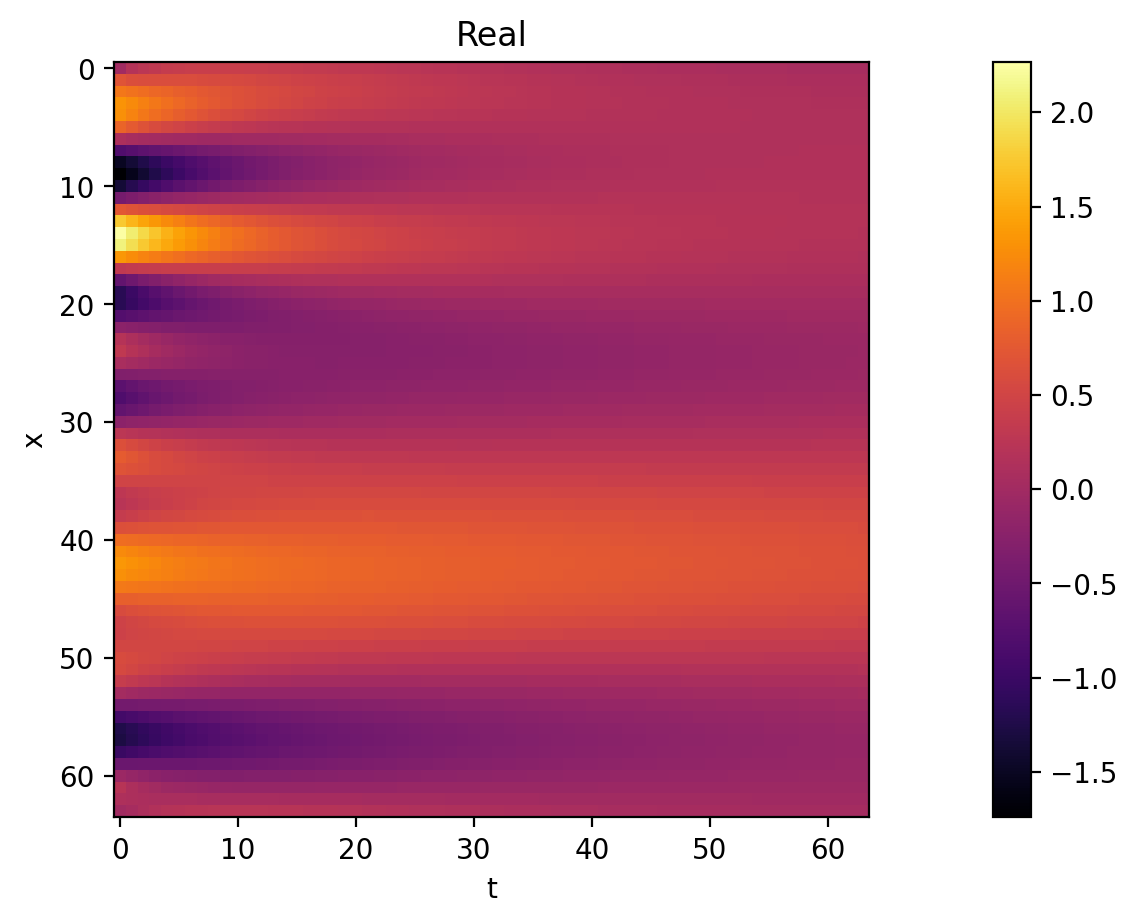

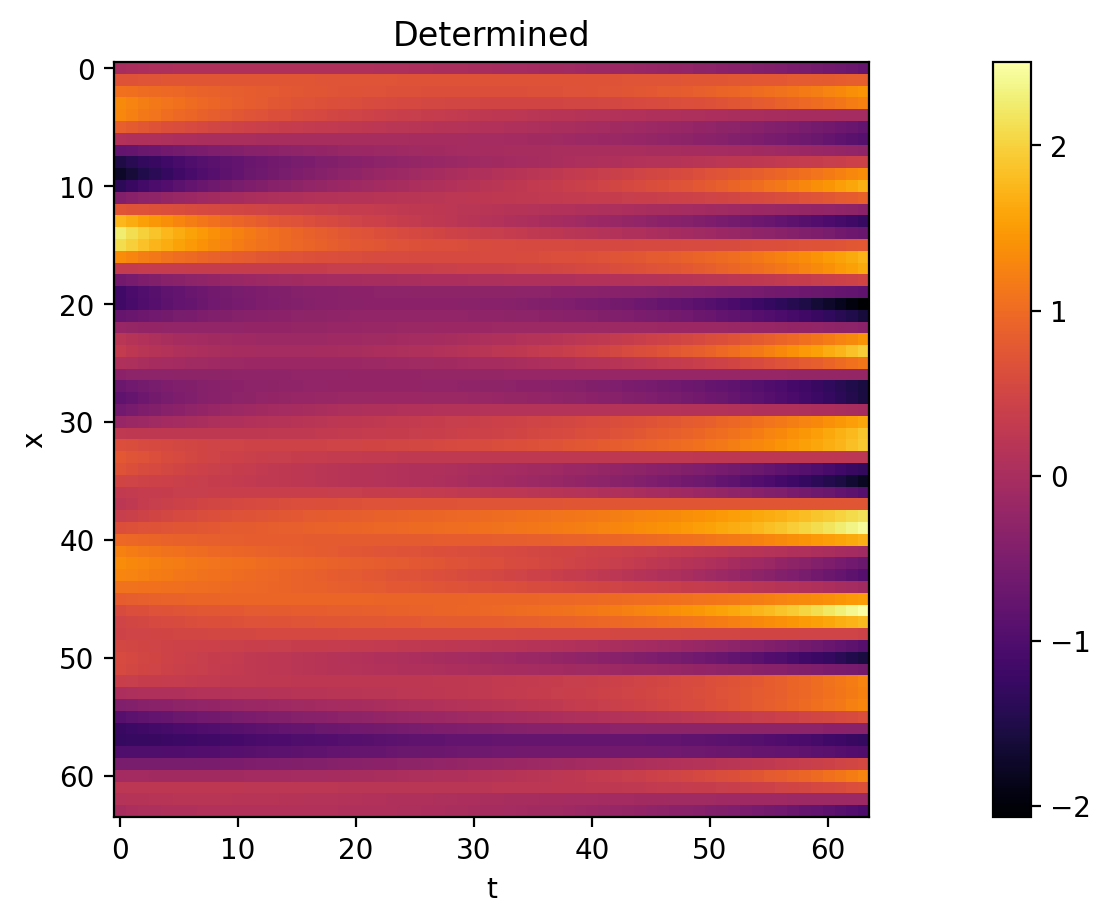

Epoch 11 loss 0.014636
Epoch 11 validation loss 0.004084
Epoch 12 loss 0.012750
Epoch 12 validation loss 0.003917
Epoch 13 loss 0.011229
Epoch 13 validation loss 0.003745
Epoch 14 loss 0.009991
Epoch 14 validation loss 0.003704
Epoch 15 loss 0.008899
Epoch 15 validation loss 0.003616
Epoch 16 loss 0.008015
Epoch 16 validation loss 0.003354
Epoch 17 loss 0.007274
Epoch 17 validation loss 0.003138
Epoch 18 loss 0.006702
Epoch 18 validation loss 0.002816
Epoch 19 loss 0.006155
Epoch 19 validation loss 0.002543
Epoch 20 loss 0.005674
Epoch 20 validation loss 0.002144


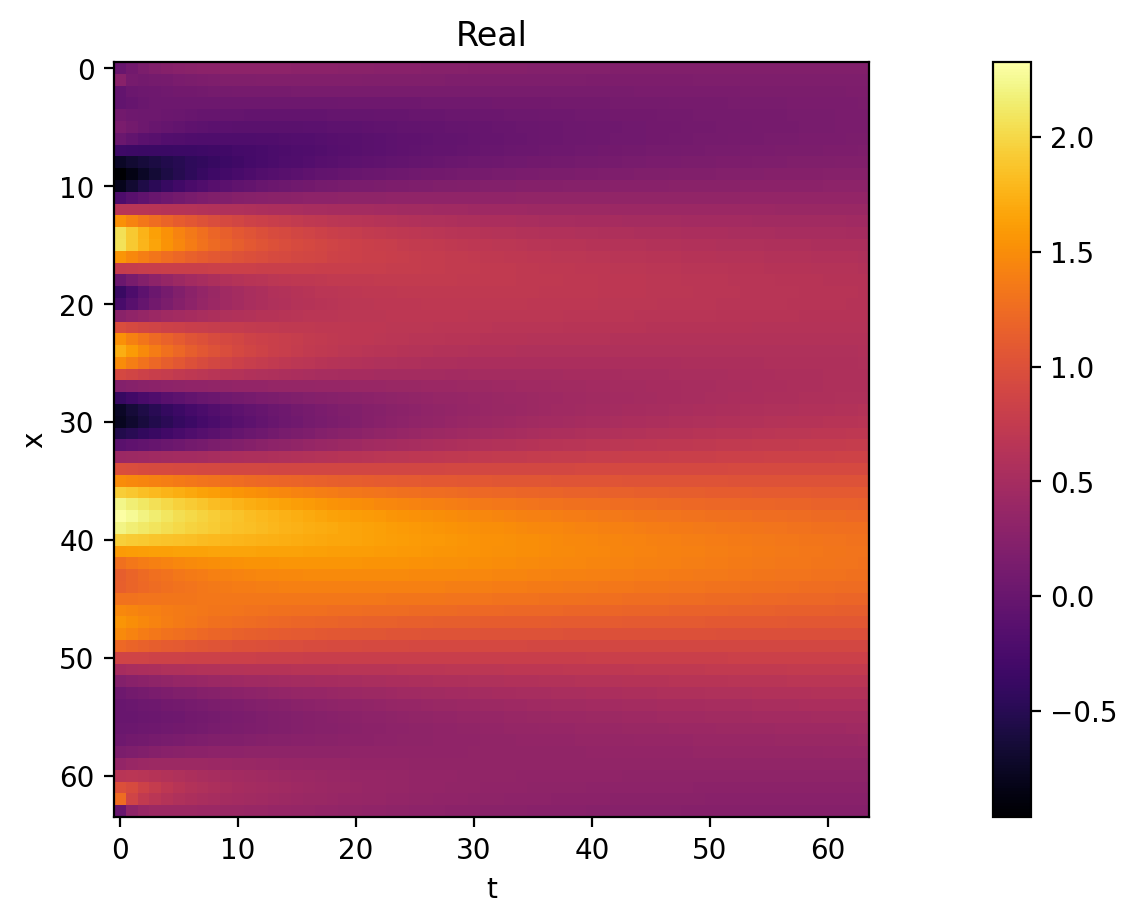

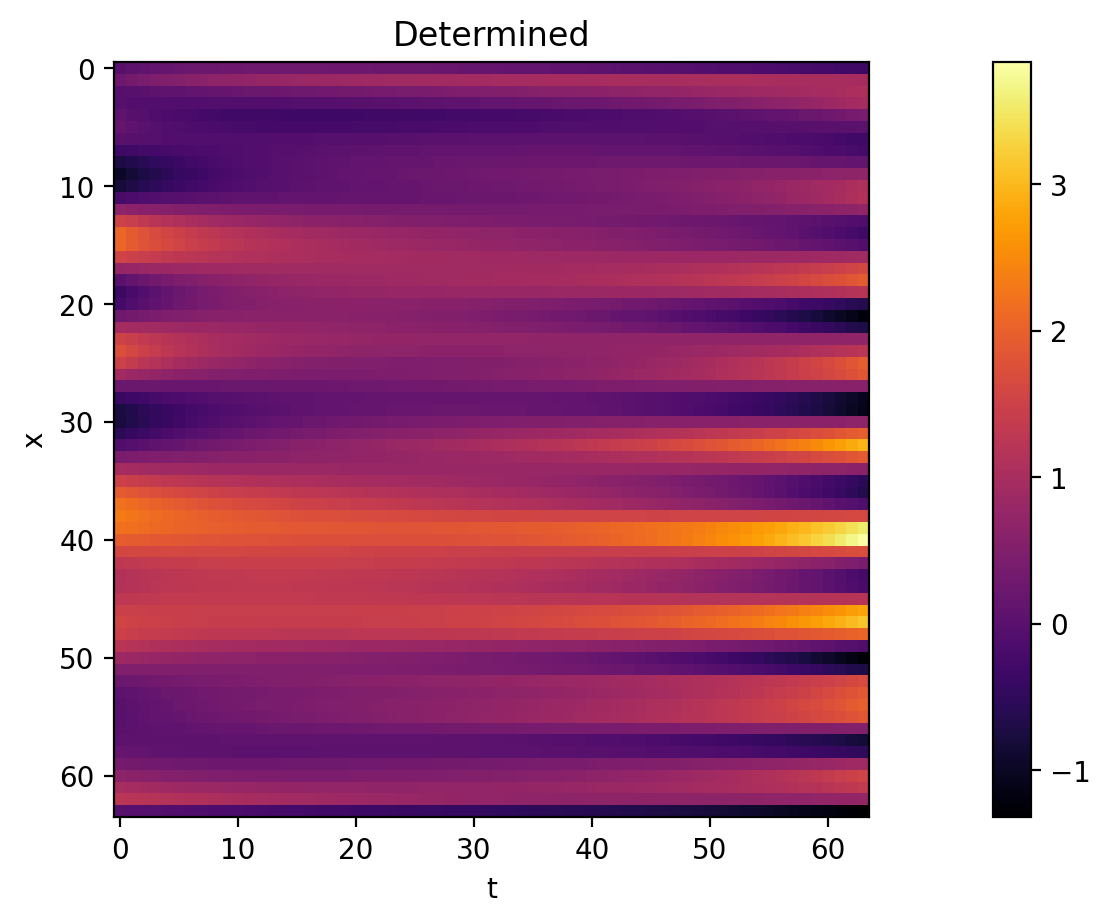

In [453]:
net = ResidualModel(x_n)
K = training_net(net, 20, t_n, x_n, dataset, 5)

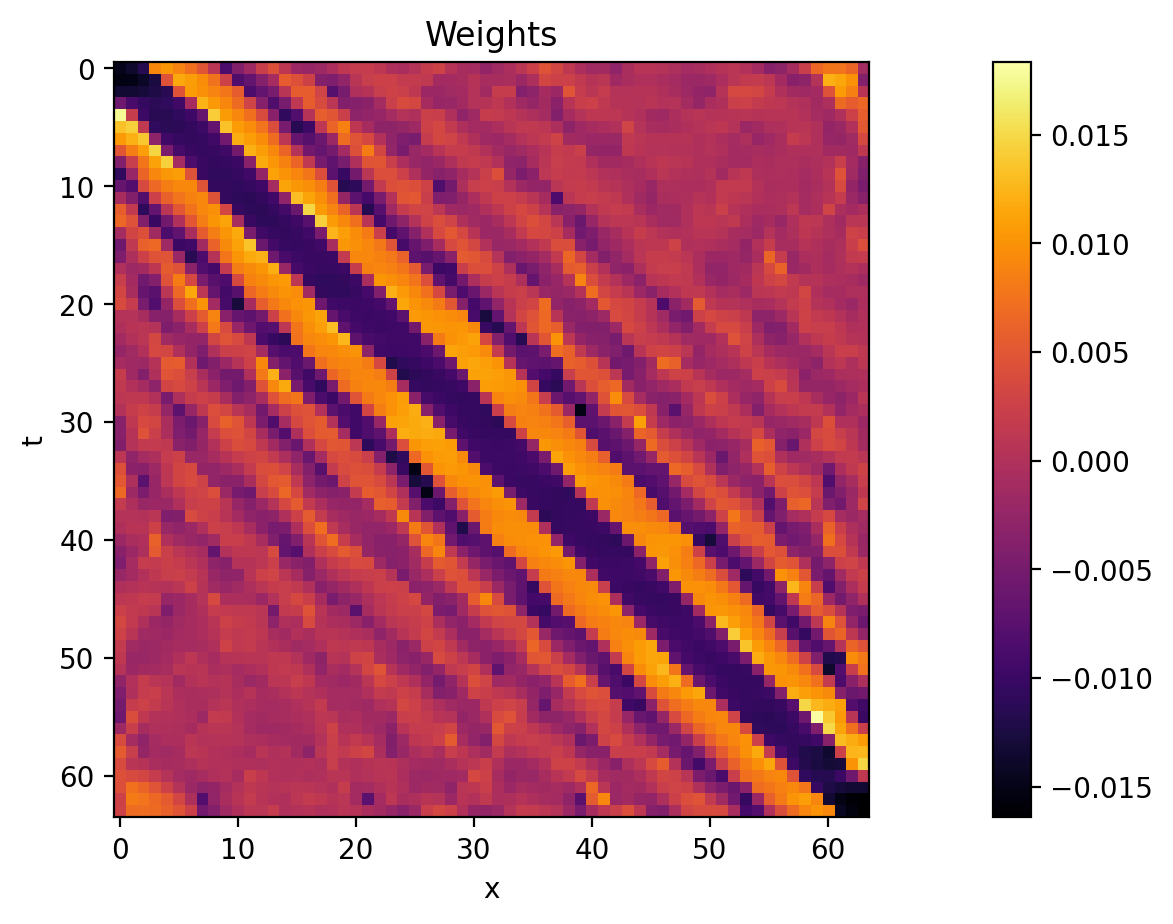

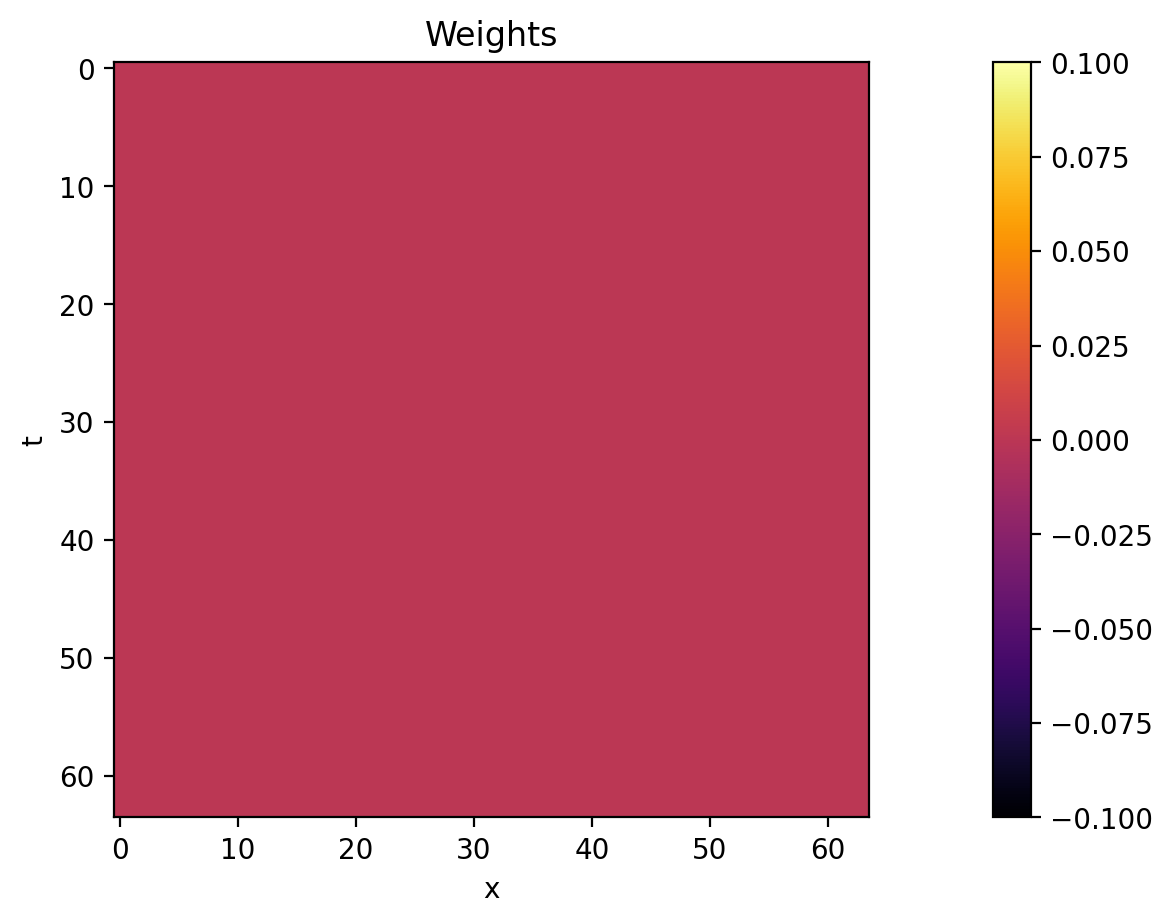

In [466]:
show_state(K.net[0].weight.detach().numpy(), "Weights")
show_state(ResidualModel(x_n).net[0].weight.detach().numpy(), "Weights")

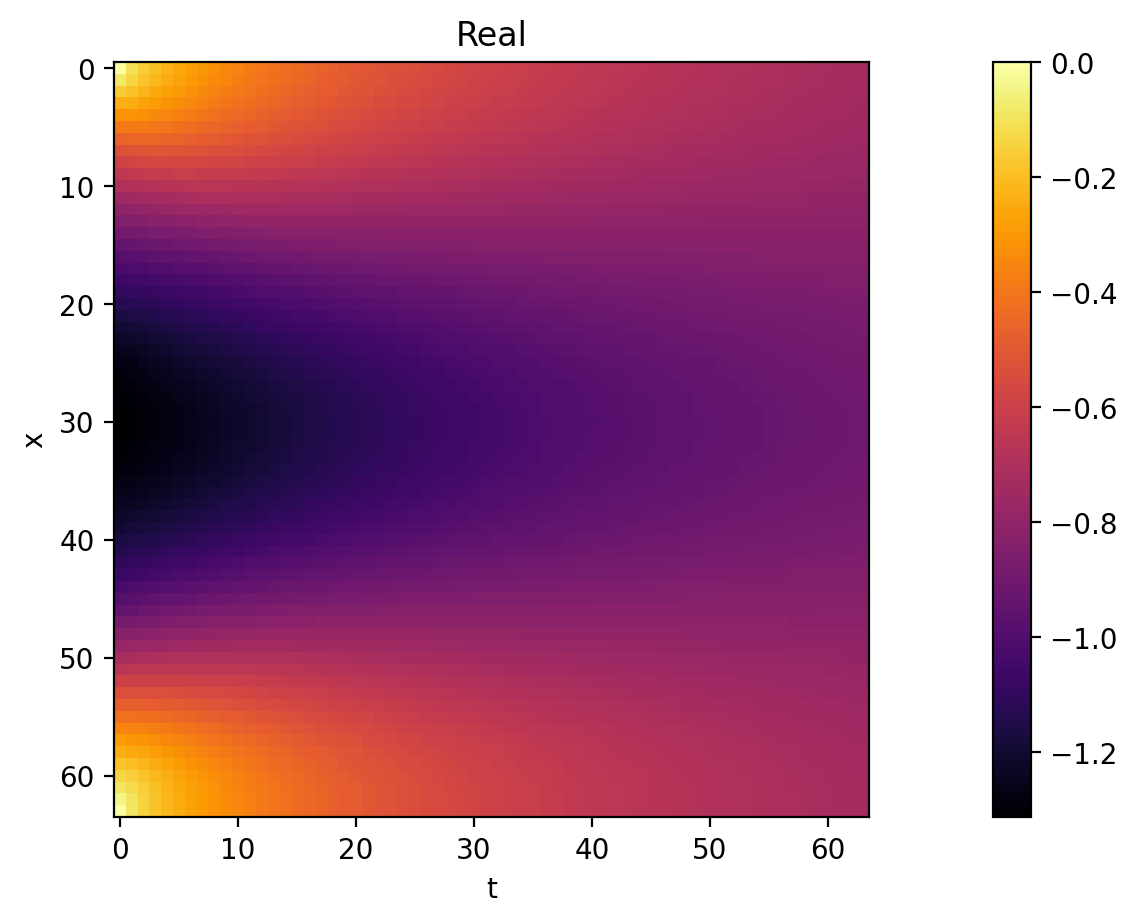

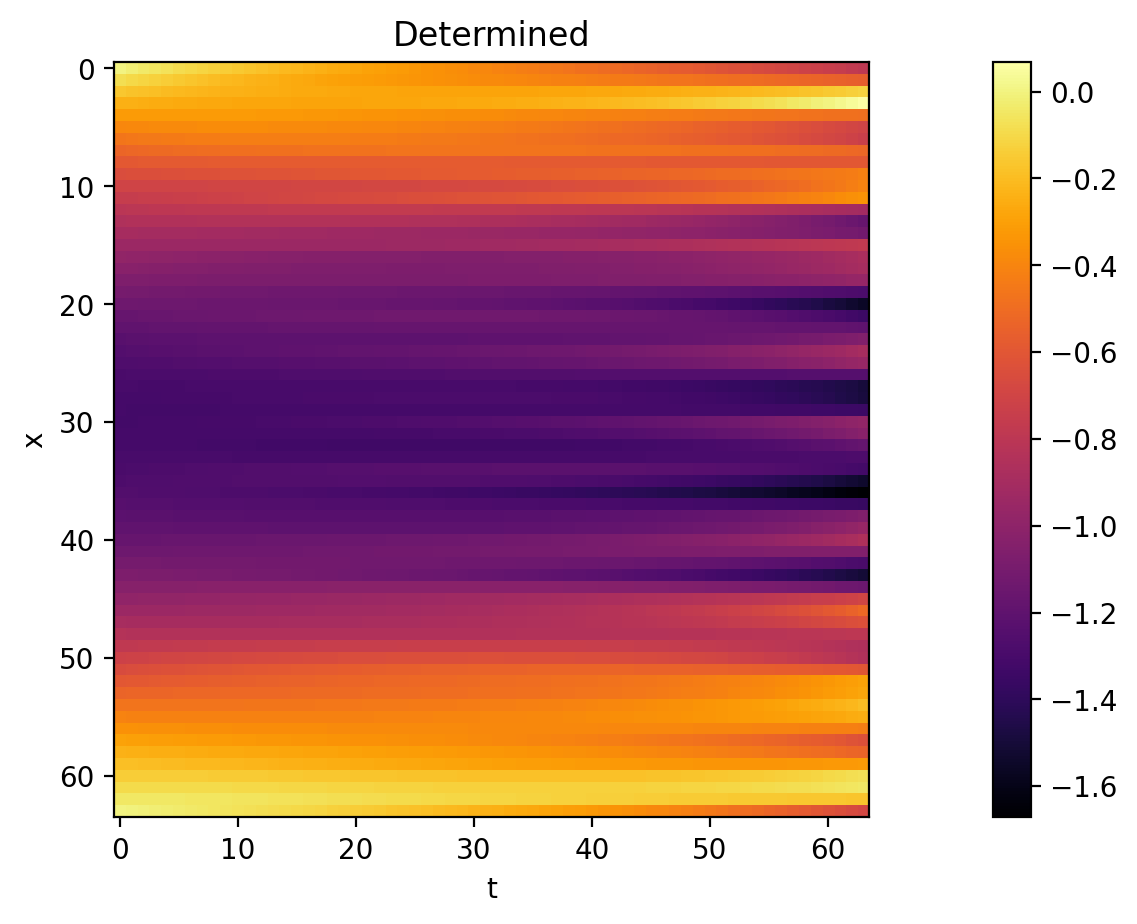

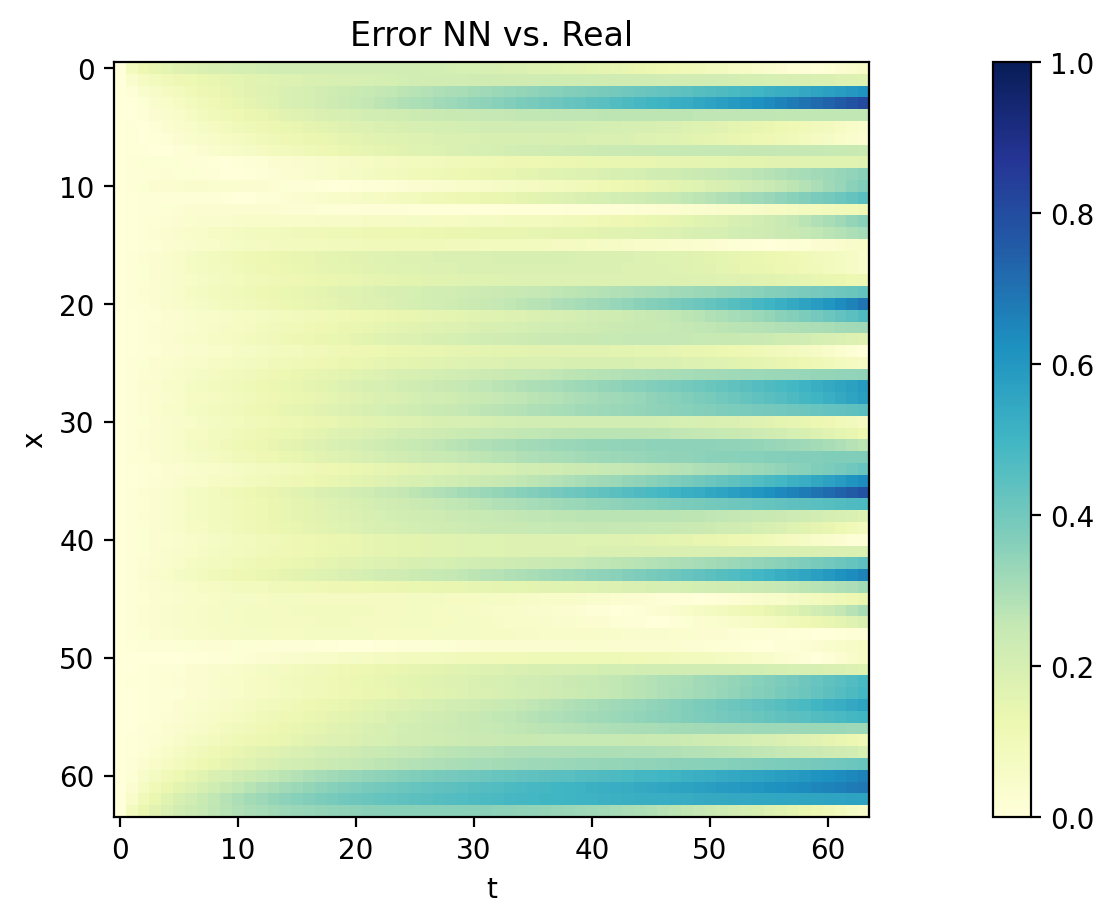

In [471]:
sample_t, sample_b0, sample_real = get_heat_batch(t_max, t_min, x_max, x_min, t_n, x_n, -1, 2, 0.05)
show_state(sample_real.T, 'Real', 't', 'x', None)
sample_pred = K(torch.from_numpy(sample_b0).float(), sample_real.shape[0])
show_state(sample_pred.detach().numpy().T, 'Determined', 't', 'x', None)
show_err(np.abs(sample_pred.detach().numpy().T - sample_real.detach().numpy().T), 'Error NN vs. Real', 't', 'x', None)

In [473]:
def check_efficiency(net, n_sim=10):
    rmse_tot = 0
    
    for i in range(n_sim):
        t, b0, u = get_heat_batch(t_max, t_min, x_max, x_min, t_n, x_n, -1, 2, 0.05)
        pred_u = K(torch.from_numpy(b0).float(), u.shape[0])
        rmse_tot += rmse(pred_u.detach().numpy(), u.detach().numpy())
        # show_err(np.abs(pred_u.detach().numpy().T - u.detach().numpy().T), 'Error NN vs. Real', 't', 'x', None)
    

    return rmse_tot / n_sim

print(check_efficiency(K, 10))

0.24244899079203605
